In [1]:
import renom as rm
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import sys
sys.path.append('../src')
from network import network
from func import Mahalanobis
from sklearn.metrics import confusion_matrix, classification_report
from time import time
from myutils import get_figratio

In [10]:
#データロードと設定
data = np.load('../data/mnist.npy', allow_pickle=True)
y_train = data[0][0]
x_train = data[0][1].astype('float32')/255.
y_test = data[1][0]
x_test = data[1][1].astype('float32')/255.
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

(60000, 784)

In [3]:
np.random.seed(10) #擬似乱数シード固定
latent_dim = 12 #潜在変数空間の次元数
epoch = 10 #学習エポック数
batch_size = 256 #バッチサイズ
opt = rm.Adam() #勾配最適化関数
# 以下はネットワーク定義
ae = network((batch_size, 28*28), epoch=epoch, latent_dim=latent_dim)

In [4]:
# 学習 （学習カーブ等はnotebook/result/内に保存、潜在変数次元が3以上は潜在変数空間をスナップショットとらない設定）
ae.train(opt, x_train, x_test, y_train, y_test)

#    1/   10 KL:2.994 ReconE:23.990 ETA:0.0sec 0.02,0.08,0.11            
*    2/   10 KL:4.910 ReconE:15.912 ETA:0.0sec 0.02,0.08,0.10            
-----------------------------------
#    3/   10 KL:5.499 ReconE:14.579 ETA:0.0sec 0.02,0.09,0.10            
*    4/   10 KL:5.451 ReconE:13.627 ETA:0.0sec 0.02,0.08,0.10            
-----------------------------------
#    5/   10 KL:5.669 ReconE:13.191 ETA:0.0sec 0.02,0.09,0.10            
*    6/   10 KL:5.454 ReconE:12.621 ETA:0.0sec 0.03,0.12,0.15            
-----------------------------------
#    7/   10 KL:5.589 ReconE:12.380 ETA:0.0sec 0.02,0.08,0.10            
*    8/   10 KL:5.296 ReconE:11.925 ETA:0.0sec 0.02,0.08,0.10            
-----------------------------------
#    9/   10 KL:5.367 ReconE:11.765 ETA:0.0sec 0.02,0.09,0.10            
*   10/   10 KL:5.067 ReconE:11.376 ETA:0.0sec 0.01,0.08,0.10            
-----------------------------------


In [5]:
#学習データの推論
_, z_train, xz_train = ae.mini_batch(opt, x_train, inference=True)

In [6]:
#推論した学習データの潜在変数ベクトルとラベルから共分散行列を計算
f = Mahalanobis(z_train, y_train)
#ラベルの外れ値をどの程度許容するか
f.set_th(0.9998)

Computing Dist
 9.775161743164062e-06sec


In [7]:
#テストデータの推論
_, z_test, xz_test = ae.mini_batch(opt, x_test, inference=True)

(0, 5)

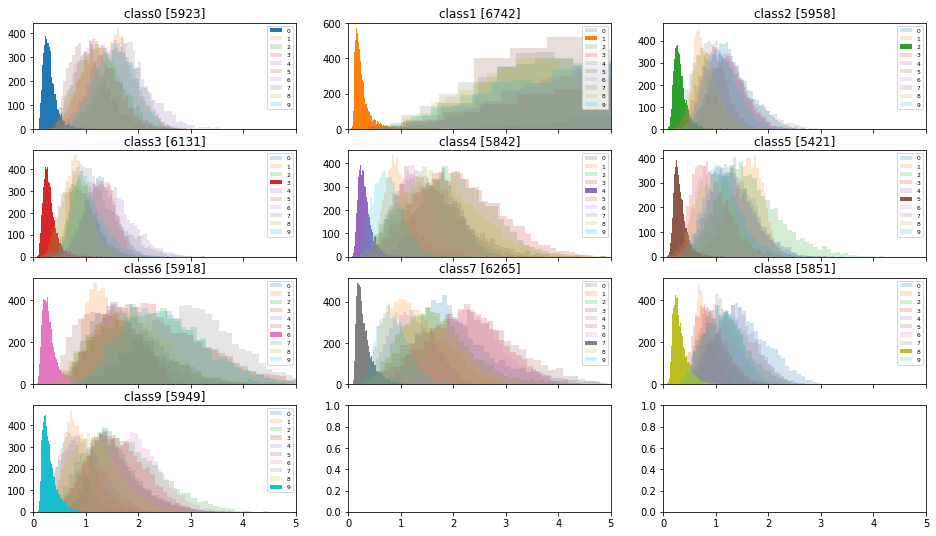

In [8]:
x, y, z = x_train, y_train, z_train
labels =np.unique(y)
nr, nc = get_figratio(len(labels))
m = []
for i in labels:
    idx = np.where(y==i)[0]
    m.append(f.predict(z[idx]))

fig, ax = plt.subplots(nr, nc, figsize=(16, 9), sharex=True)
for _ax, i in zip(ax.flat, labels):
    _ax.set_title(f'class{i} [{len(m[i])}]')
    for j in labels:
        a = 1 if i==j else 0.2
        h, e = np.histogram(m[j].T[i], bins='auto')
        fc = plt.get_cmap('tab10')(j/9)
        _ax.bar(e[:-1], h, e[1:]-e[:-1], align='edge', fc=fc, alpha=a, label=f'{j}')
    _ax.legend(fontsize=6, loc=1)
_ax.set_xlim(0, 5)

In [32]:
from scipy.stats import skew
from itertools import product
import pandas as pd
n = len(np.unique(y_train))
stat = []
for i in range(n):
    _m = m[i][:,i]**2
    stat.append([_m.mean(), _m.var(), skew(_m)])
idx = [f'C{i}' for i in range(n)]
for k in range(1, 4):
    stat.append([k, 2*k, (8/k)**0.5])
    idx.append(f'R{k}')
pd.DataFrame(stat, index=idx, columns=['mean', 'variance', 'skewness'])



,mean,variance,skewness
C0,0.123808,0.020780,5.782104
C1,0.239389,1.471074,18.104452
C2,0.119501,0.012722,3.960828
C3,0.123437,0.018831,4.957852
C4,0.123693,0.021931,7.888130
C5,0.120791,0.015526,5.594797
C6,0.130675,0.031275,5.959296
C7,0.136179,0.037456,5.648905
C8,0.125969,0.020215,4.251892
C9,0.132494,0.038709,7.108164


(0, 5)

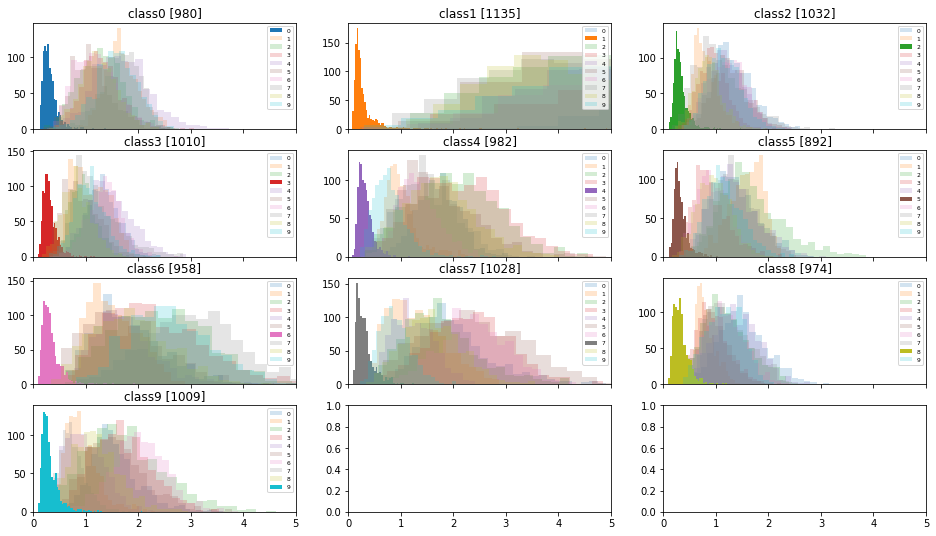

In [63]:
x, y, z = x_test, y_test, z_test
labels =np.unique(y)
nr, nc = get_figratio(len(labels))
m = []
for i in labels:
    idx = np.where(y==i)[0]
    m.append(f.predict(z[idx]))

fig, ax = plt.subplots(nr, nc, figsize=(16, 9), sharex=True)
for _ax, i in zip(ax.flat, labels):
    _ax.set_title(f'class{i} [{len(m[i])}]')
    for j in labels:
        a = 1 if i==j else 0.2
        h, e = np.histogram(m[j].T[i], bins='auto')
        fc = plt.get_cmap('tab10')(j/9)
        _ax.bar(e[:-1], h, e[1:]-e[:-1], align='edge', fc=fc, alpha=a, label=f'{j}')
    _ax.legend(fontsize=6, loc=1)
_ax.set_xlim(0, 5)

In [36]:
#テストデータの潜在変数ベクトルからクラス分類
process_t = time()
pred = np.argmin(f.predict(z_test), 1)
print('{:.2f}sec'.format(time()-process_t))
matrix = confusion_matrix(y_test, pred)
print(matrix)
print(classification_report(y_test, pred))

6.58sec
[[ 960    0    1    1    0    9    1    1    7    0]
 [   0 1058   14   15    2    0    2    2   40    2]
 [  16    0  978    3    6    2    4    5   16    2]
 [   6    0    9  942    0   15    0    7   26    5]
 [   4    0    8    0  934    3    2    3    2   26]
 [  12    0    4   21    5  835    3    2    9    1]
 [  15    1    6    0    5   26  900    0    5    0]
 [   2    3   54    2    5    3    0  909    4   46]
 [   6    0   10   27    7   25    2    3  887    7]
 [   6    2    5   13   31    5    0   11   11  925]]
             precision    recall  f1-score   support

          0       0.93      0.98      0.96       980
          1       0.99      0.93      0.96      1135
          2       0.90      0.95      0.92      1032
          3       0.92      0.93      0.93      1010
          4       0.94      0.95      0.94       982
          5       0.90      0.94      0.92       892
          6       0.98      0.94      0.96       958
          7       0.96      0.88    

54 (7, 2)
46 (7, 9)
40 (1, 8)
31 (9, 4)
27 (8, 3)
26 (3, 8)
26 (4, 9)
26 (6, 5)
25 (8, 5)
21 (5, 3)


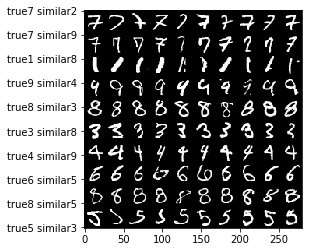

In [111]:
check = matrix.copy()
for i in range(10):
    check[i, i] = 0
smlr = []
for i in range(10):
    i = np.where(check==check.max())
    #print(check[i], [tuple(x) for x in zip(*i)])
    for x in zip(*i):
        print(check[x], tuple(x))
        smlr.append(tuple(x))
    check[i] = 0
    if len(smlr)>=10:
        break

idx = []
for i, j in smlr:
    _idx = np.where(y_test==i)[0]
    _idx = _idx[pred[_idx]==j]
    _idx = _idx[np.random.permutation(len(_idx))]
    idx = idx + list(_idx[:10])

im = x_test[idx].reshape(10, 10, 28, 28).transpose(0, 2, 1, 3).reshape(10*28, 10*28)
plt.imshow(im, cmap='gray')
ticks = np.linspace(0, 10*28-1, 10).astype('int')
_ = plt.yticks(ticks, [f'true{x[0]} similar{x[1]}' for x in smlr])

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(z_train, y_train.reshape(-1))

In [35]:
process_t = time()
pred = knn.predict(z_test)
print('{:.2f}sec'.format(time()-process_t))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

4.88sec
[[ 965    1    4    0    0    1    5    2    1    1]
 [   0 1128    3    1    1    0    1    0    1    0]
 [   8    0  996    4    1    0    2    8   13    0]
 [   2    0   11  950    1   13    0    8   23    2]
 [   1    0    2    0  936    0    6    2    2   33]
 [   4    2    1   21    1  842    8    1    9    3]
 [   1    4    1    0    3    6  941    0    2    0]
 [   0   12   15    0    7    0    0  976    0   18]
 [   3    0    5   18    3   10    2    4  927    2]
 [   2    3    3    8   24    0    1   11    8  949]]
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.96      0.97      0.96      1032
          3       0.95      0.94      0.94      1010
          4       0.96      0.95      0.96       982
          5       0.97      0.94      0.95       892
          6       0.97      0.98      0.98       958
          7       0.96      0.95    

In [3]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train.reshape(-1))

In [112]:
pred = xgb.predict(x_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 967    0    1    0    0    3    3    1    4    1]
 [   0 1117    4    2    0    1    4    1    6    0]
 [  11    1  961   15   10    0    6   12   13    3]
 [   5    0   20  927    2   16    4   10   15   11]
 [   1    1    2    0  908    2    9    2    5   52]
 [   7    2    1   21    3  815    9    5   18   11]
 [  10    4    0    0    7   13  911    2   11    0]
 [   4    7   25    7    5    2    0  948    4   26]
 [   5    4    5   11    9    6   14    6  895   19]
 [   8    8    2   12   30    5    1   13   11  919]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       980
          1       0.98      0.98      0.98      1135
          2       0.94      0.93      0.94      1032
          3       0.93      0.92      0.92      1010
          4       0.93      0.92      0.93       982
          5       0.94      0.91      0.93       892
          6       0.95      0.95      0.95       958
          7       0.95      0.92      0.93  

/Users/yamagishi/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [113]:
from model import Model

In [114]:
def onehot(na):
    _na = np.zeros((len(na), len(np.unique(na))))
    for i,j in enumerate(na):
        _na[i, j] = 1
    return _na
Y_train = onehot(y_train)
Y_test = onehot(y_test)

In [115]:
arch = {
    'input_shape' : x_train.shape[1],
    'output_shape' : Y_train.shape[1],
    'depth' : 3,
    'unit' : 256,
    'loss' : rm.softmax_cross_entropy,
    #'output_idx' : [-1],
    'debug' : True,
}
params = {
    'epoch' : 10,
    'batch' : 256,
    'opt' : [rm.Adam, {'lr':0.0008, 'b':0.7}],
    'seed' : 42,
    'anneal' : [3, 5],
    'arch' : arch
}
clf_nn = Model(**params)

In [116]:
clf_nn.fit(x_train, Y_train, x_test, Y_test, fname=f'check.png')

00010/00010 0.003096 132.873795 @ 8.59sec


In [117]:
pred = clf_nn.predict(x_test)
pred = np.argmax(pred, 1)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 967    0    1    2    0    0    2    6    1    1]
 [   1 1113    4    5    0    1    2    7    2    0]
 [   0    0 1019    3    1    1    0    5    2    1]
 [   0    0    3  995    0    2    0    3    3    4]
 [   1    0    8    0  950    0    3    5    0   15]
 [   0    0    0   11    2  866    4    1    3    5]
 [   5    2    6    1    2    3  932    4    3    0]
 [   1    0    6    1    0    1    0 1017    1    1]
 [   1    2    9   15    5    3    0    4  932    3]
 [   1    1    0    2    7    1    0   12    2  983]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       980
          1       1.00      0.98      0.99      1135
          2       0.96      0.99      0.98      1032
          3       0.96      0.99      0.97      1010
          4       0.98      0.97      0.97       982
          5       0.99      0.97      0.98       892
          6       0.99      0.97      0.98       958
          7       0.96      0.99      0.97  

In [122]:
check = confusion_matrix(y_test, pred)
n = 7
for i in range(10):
    check[i, i] = 0
smlr = []
for i in range(10):
    i = np.where(check==check.max())
    #print(check[i], [tuple(x) for x in zip(*i)])
    for x in zip(*i):
        print(check[x], tuple(x))
        smlr.append(tuple(x))
    check[i] = 0
    if len(smlr)>=n:
        break

idx = []
for i, j in smlr:
    _idx = np.where(y_test==i)[0]
    _idx = _idx[pred[_idx]==j]
    _idx = _idx[np.random.permutation(len(_idx))]
    idx = idx + list(_idx[:n])

im = x_test[idx].reshape(n, n, 28, 28).transpose(0, 2, 1, 3).reshape(n*28, n*28)
plt.imshow(im, cmap='gray')
ticks = np.linspace(0, n*28-1, n).astype('int')
_ = plt.yticks(ticks, [f'true{x[0]} similar{x[1]}' for x in smlr])

15 (4, 9)
15 (8, 3)
12 (9, 7)
11 (5, 3)
9 (8, 2)
8 (4, 2)
7 (1, 7)
7 (9, 4)


ValueError: cannot reshape array of size 43904 into shape (7,7,28,28)

In [123]:
len(idx)

56